In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from env import get_db_url

In [2]:
# Find all of the "Single Family Residential" properties from 2017.
sql = """
select 
bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
from properties_2017
join propertylandusetype using (propertylandusetypeid)
where propertylandusedesc = "Single Family Residential"
"""

df = pd.read_sql(sql, get_db_url("zillow"))
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
# What's the percentage of nulls?
df.isna().mean()

bedroomcnt                      0.000005
bathroomcnt                     0.000005
calculatedfinishedsquarefeet    0.003941
taxvaluedollarcnt               0.000229
yearbuilt                       0.004337
taxamount                       0.002063
fips                            0.000000
dtype: float64

In [28]:
# renaming columns
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built',
                          'taxamount':'tax_amount'})

In [29]:
# If we drop all rows containing any null, how much data do we have left?
round(df.dropna().shape[0] / df.shape[0], 4)

1.0

In [30]:
df.shape[0]

2094583

In [31]:
# I'm comfortable dropping the rows with nulls
df = df.dropna()

In [32]:
df.columns.tolist()

['bedrooms',
 'bathrooms',
 'area',
 'tax_value',
 'year_built',
 'tax_amount',
 'fips']

In [33]:
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-----------------")

bedrooms
3    955909
4    621076
2    332538
5    138255
1     22724
6     19800
0      4281
Name: bedrooms, dtype: int64
-----------------
bathrooms
2.00    940253
3.00    416455
1.00    412088
2.50    142178
4.00     74214
1.50     31112
3.50     26778
5.00     20923
4.50     16820
6.00      5412
0.00      4183
5.50      4151
0.50        13
1.75         3
Name: bathrooms, dtype: int64
-----------------
area
1200    5182
1080    4372
1120    4350
1400    3822
1440    3681
        ... 
7452       1
7553       1
6539       1
7582       1
7026       1
Name: area, Length: 7156, dtype: int64
-----------------
tax_value
450000     820
500000     772
400000     722
430000     689
440000     682
          ... 
631975       1
557761       1
900571       1
1285615      1
536061       1
Name: tax_value, Length: 557433, dtype: int64
-----------------
year_built
1955    83829
1950    70957
1954    68597
1953    61835
1956    61419
        ...  
1855        1
1823        1
1807        1
1877       

### Takeaways so far:
- Bedrooms can be an integer
- Bathrooms can stay a float to keep the .5 bathrooms
- Year built, FIPS, and taxvaluedollarcnt can be converted to integers w/o data loss

In [34]:
# 100% of calculatedfinishedsquarefeet can be converted to int w/o data loss
(df.area == df.area.astype(int)).mean()

1.0

In [35]:
# 100% of taxvaluedollarcnt can lose the deicimal and be OK
(df.tax_value == df.tax_value.astype(int)).mean()

1.0

In [36]:
(df.bathrooms == df.bathrooms.astype(int)).mean()

0.8944634803204266

In [37]:
# fips, yearbuilt, and bedrooms can be integers
df["fips"] = df["fips"].astype(int)
df["year_built"] = df["year_built"].astype(int)
df["bedrooms"] = df["bedrooms"].astype(int)
df["tax_value"] = df["tax_value"].astype(int)
df["area"] = df["area"].astype(int)

In [38]:
df.dtypes

bedrooms        int64
bathrooms     float64
area            int64
tax_value       int64
year_built      int64
tax_amount    float64
fips            int64
dtype: object

## Above Data Wrangling now lives in `wrangle.py`
- There's also a CSV caching layer in the wrangle_zillow function.

# Histogram All The Things!

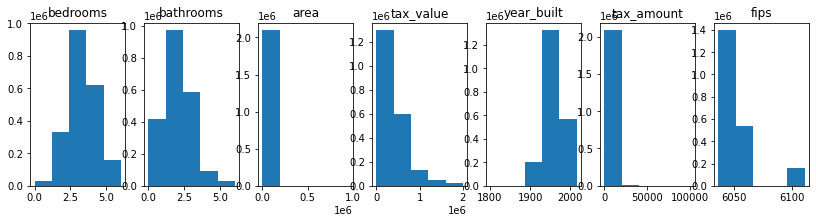

In [39]:
plt.figure(figsize=(16, 3))

# List of columns
for i, col in enumerate(df.columns):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)


## Just Because It's Automatable Doesn't Mean It's Legible :)

bedrooms


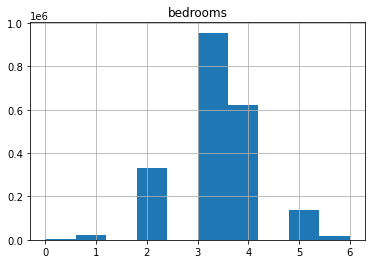

bathrooms


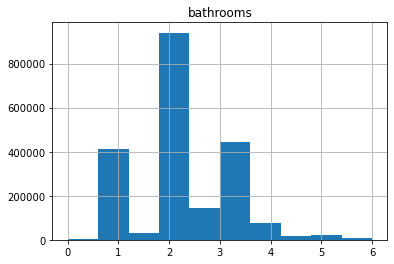

area


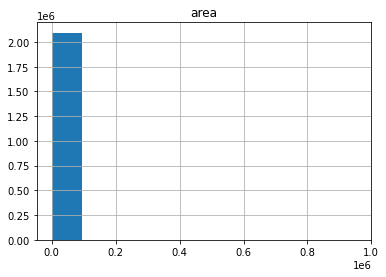

tax_value


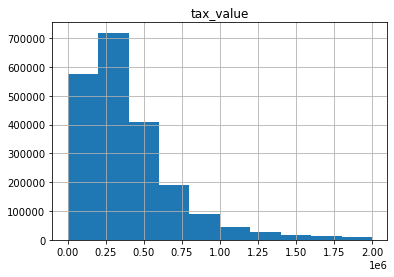

year_built


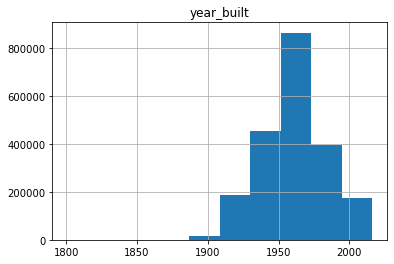

tax_amount


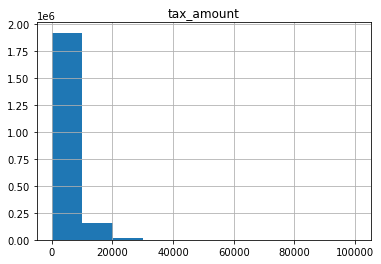

fips


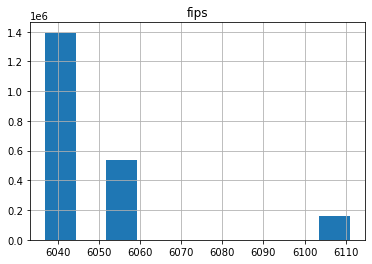

In [40]:
for col in df.columns:
    print(col)
    plt.title(col)
    df[col].hist()
    plt.show()

## Let's See about handling outliers
- I'm going to remove properties that are larger than half a football field, 25000 sqft (46 records)
- Those >= 25_000 sqft properties average a tax value north of $21m. 
- I'm going 

In [41]:
# A football field is 57,600 square feet
df.area.sort_values(ascending=False).head(10)

826937     952576
1643612    531118
808042      59220
2024381     37634
1476750     31653
1941470     29620
450494      28609
1449873     26450
1618548     24220
1037170     23888
Name: area, dtype: int64

In [42]:
df[df.area >= 25_000].tax_value.mean()

682621.25

In [43]:
# Most Zillow customers share more in common with you and me than a movie star with 25 bedrooms.
df.bedrooms.value_counts()

3    955909
4    621076
2    332538
5    138255
1     22724
6     19800
0      4281
Name: bedrooms, dtype: int64

In [44]:
df.bathrooms.sort_values(ascending=False).head(30)

284946     6.0
1442249    6.0
620014     6.0
24628      6.0
915500     6.0
1154724    6.0
1154737    6.0
1511264    6.0
1697871    6.0
1441281    6.0
619499     6.0
2035594    6.0
974157     6.0
2035610    6.0
974159     6.0
1634812    6.0
767676     6.0
1154867    6.0
1089026    6.0
1967807    6.0
1697906    6.0
1511380    6.0
1634778    6.0
22117      6.0
1634961    6.0
1697741    6.0
22121      6.0
522217     6.0
916814     6.0
1510425    6.0
Name: bathrooms, dtype: float64

## Manual Outlier Detection and Filtering

> WHO is actually using Zillow? Is it folks with 25 bedrooms? Or folks who shop closer to you and me?


In [45]:
# What percentage of properties have 6 or less bathrooms?
df[df.bathrooms <= 6].shape[0] / df.shape[0]

1.0

In [46]:
# What percentage of properties have 6 or less bedrooms?
df[df.bedrooms <= 6].shape[0] / df.shape[0]

1.0

In [47]:
# What percentage of properties are less than $2m in tax value?
df[df.tax_value < 1_500_000].shape[0] / df.shape[0]

0.9859652255365388

In [48]:
# Import the wrangle_zillow where I've dropped some outliers already
from wrangle import wrangle_zillow

In [52]:
df = wrangle_zillow()

In [53]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
0,4,2.0,3633,296425,2005,6941.39,6037
1,3,4.0,1620,847770,2011,10244.94,6037
2,3,2.0,2077,646760,1926,7924.68,6037
3,0,0.0,1200,5328,1972,91.60,6037
4,0,0.0,171,6920,1973,255.17,6037


bedrooms


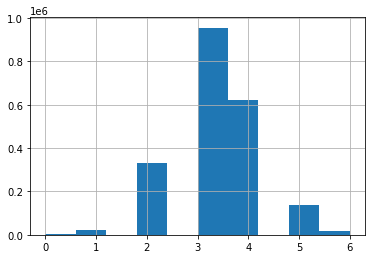

bathrooms


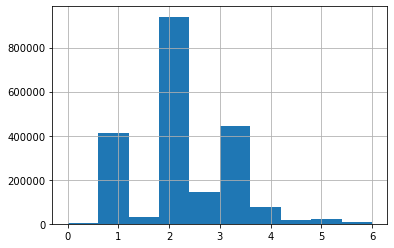

area


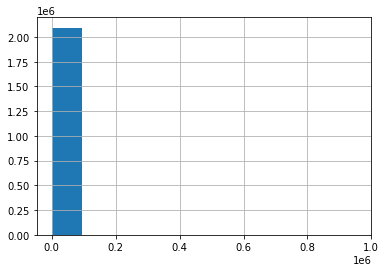

tax_value


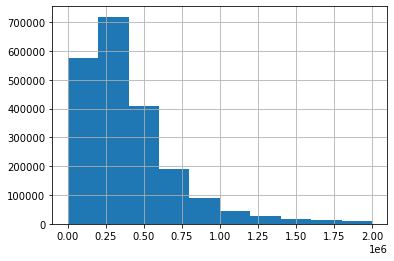

year_built


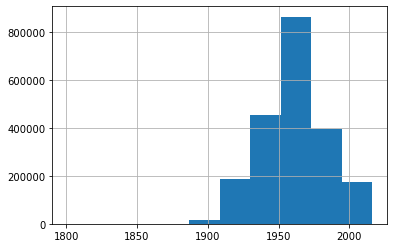

tax_amount


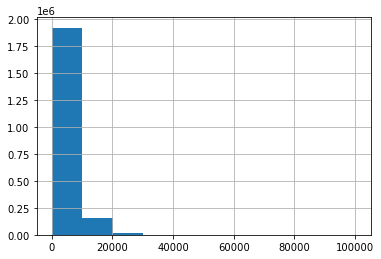

fips


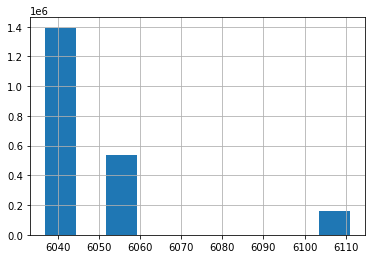

In [54]:
for col in df.columns:
    print(col)
    df[col].hist()
    plt.show()